In [23]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from pickle import dump, load
import os
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [24]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> crossentropy já aplica softmax
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = (self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [25]:
# Read xlsx with nets info
df_nets = pd.read_excel('classification_nets.xlsx', index_col=None, header=0)
df_nets

,Net,random_state,num_layers,layers_size,net_param,criterion,learning_rate,optimizer,epochs,vali_best_epoch,...,vali_best_R,vali_sur_acc,vali_sur_loss,vali_sur_R,test_acc,test_loss,test_R,predicted,c_matrix,c_matrix_perc
0,0,0,4,"[23, 3, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.041,Adam,50000,43000,...,0.818282,tensor(20),14.765882,-0.130773,47,7.227311,0.236648,[3 1 1 2 1 1 1 1 1 1 3 1 3 1 3 1 1 1 1 2 1 1 1...,[[ 0 5 3 1]\n [ 0 18 0 3]\n [ 0 8 3 0]...,[[ 0. 55.55555556 33.33333333 11.11111...


In [22]:
print(max(df_nets['test_acc']))
np.where(df_nets['test_acc']==max(df_nets['test_acc']))

49


(array([111], dtype=int64),)

In [5]:
net_number = 111
netX = df_nets.iloc[net_number]
netX

Net                                                              111
random_state                                                    6511
num_layers                                                         4
layer_init_size                                                    3
layers_size                                                  [3 3 4]
net_param          <bound method Module.parameters of Net(\n  (li...
criterion                                           CrossEntropyLoss
learning_rate                                                  0.001
optimizer                                                       Adam
epochs                                                         50000
vali_best_epoch                                                50000
vali_best_acc                                                     33
vali_best_loss                                               28.4282
vali_best_R                                                0.0387613
test_acc                          

In [6]:
# Load dataset
X_test = np.load('X_test.npy')
y_test_class = np.load('y_test_class.npy')

In [8]:
# # Muda para o diretório de interesse
# os.chdir("./Nets/Net0/")

pasta = "./Nets/Net"+str(net_number)+"/"

In [9]:
# Transformando o dado de teste
# load the scaler
scaler_x = load(open(pasta +'scaler_x.pkl', 'rb'))
X_test_scaled = scaler_x.transform(X_test)

In [10]:
# Parâmetros da rede
torch.manual_seed(1234)

# num_layers = rede.iloc[0,2]
num_layers = netX['num_layers']
print('Number of layers: %d' % (num_layers))
layer_init_size = netX['layer_init_size']
print('Inicial size layer: %d' % (layer_init_size))
layers_size = np.linspace(layer_init_size, 4, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X_test.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)

Number of layers: 4
Inicial size layer: 3
Layers sizes: [3, 3, 4]


In [11]:
# Choose optmizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

# to load
checkpoint = torch.load(pasta +'model_best.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [12]:
checkpoint['epoch']

50000

In [13]:
checkpoint['loss']

28.428157806396484

In [14]:
checkpoint['R-corrcoef']

0.03876133985538298

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Errors: 32; Accuracy: 49%
Teste Loss: 57.8313
R-corrcoef: 0.3823465417758706


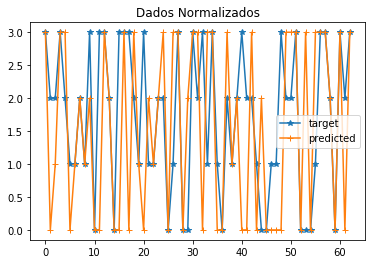

In [15]:
# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_class).long())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets.squeeze())
loss.backward()
optimizer.step()

_, predicted = torch.max(out.data, 1)       

error_count = y_test_class.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_class.size
r = np.corrcoef(predicted.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
print('Teste Loss: %.4f' % (loss.item()))
print('R-corrcoef: %s' % (str(r)))


ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_class, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()

In [16]:
netX

Net                                                              111
random_state                                                    6511
num_layers                                                         4
layer_init_size                                                    3
layers_size                                                  [3 3 4]
net_param          <bound method Module.parameters of Net(\n  (li...
criterion                                           CrossEntropyLoss
learning_rate                                                  0.001
optimizer                                                       Adam
epochs                                                         50000
vali_best_epoch                                                50000
vali_best_acc                                                     33
vali_best_loss                                               28.4282
vali_best_R                                                0.0387613
test_acc                          

In [26]:
netX['predicted']

'tensor([3, 0, 1, 3, 3, 0, 1, 2, 1, 2, 0, 0, 3, 2, 0, 0, 3, 0, 3, 1, 0, 2, 1, 2,\n        3, 0, 3, 3, 0, 2, 3, 3, 0, 3, 3, 0, 0, 3, 1, 2, 0, 0, 3, 0, 2, 0, 0, 0,\n        0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 2, 0, 3, 0, 3])'

In [18]:
predicted.numpy()

array([3, 0, 1, 3, 3, 0, 1, 2, 1, 2, 0, 0, 3, 2, 0, 0, 3, 0, 3, 1, 0, 2,
       1, 2, 3, 0, 3, 3, 0, 2, 3, 3, 0, 3, 3, 0, 0, 3, 1, 2, 0, 0, 3, 0,
       2, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 2, 0, 3, 0, 3],
      dtype=int64)

In [19]:
netX['num_layers'].dtype

dtype('int64')

# Adaptar com as novas alterações do loop